#### This is a [jupyter](https://jupyter.org/) notebook that contains text, equations, images and executable code in one document.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
%matplotlib inline

# Finite Elements: Numerical Integration (Quadrature)
In the FEM, we want to integrate functions containing the field quantities over the domain. After partitioning of the domain into finite elements, this means we have to compute the integrals over the finite elements. The expression in the integral is a function that is approximated based on an interpolation of the field quantities using shape functions. If we assume that the shape functions are polynomial functions, then the integrand will also be a polynomial function (possibly of higher order).

It is straightforward to compute the integral of a polynomial function. It is, however, not straightforward to do so if the integral is multidimensional (two- or three-dimensional). Therefore, we have to approximate those integrals numerically. Note, that this is the second approximation after the introduction of shape functions.

## Basics: one-dimensional quadrature
While it is not always necessary to use numerical integration in one dimension, we will start here with this to understand the general idea. First, we consider integration over a **standard interval** $(-1,1)$. The integral is then generally approximated by:

\begin{equation}
I = \int_{-1}^{1} g(r) \mathrm{d} r \approx \sum_{i=1}^{N} w_{i} g\left(r_{i}\right).
\end{equation}

where $r_i$ are the **quadrature points** (support points at which the function $g$ is evaluated) and $w_i$ are the **weights**. The sum has $N$ summands, which means that the quadrature is of order $N$.

### Newton-Cotes
For the choice of the quadrature points and weights exists a large number of different variants. The most simple way of determining them is probably the use of the Newton-Cotes formulas. They assume equidistant support points:

| order $N$ |Newton-Cotes formula with weights and points | name  |
|---|---|:-|
| 1  | $I\approx2 g(0)$  | rectangle rule  |
| 2  | $I\approx g(-1)+g(1)$  | trapezoidal rule  |
| 3  | $I\approx \frac{1}{3}\left(g(-1)+4g(0)+g(1)\right)$  | Simpson's rule  |
| 4  | $I\approx \frac{1}{4}\left(g(-1)+3g(-\frac{1}{3})+3g(+\frac{1}{3})+g(1)\right)$  | Simpson's 3/8 rule  |

While these formulas are simple, they are error-free only for polynomials up to a degree of $N$ or $N-1$, e.g. one needs at least 3 support points to integrate a polynomial of degree 2 (a quadratic function).


###  Gauss
If the integrand is a polynomial function, the Gauss or Gauss-Legendre quadrature formulas give the best accuracy for a given number of support points. They are exact up to polynomial order $2N-1$, e.g. just 2 support points for a quadratic function. Support points and weight are not so easy to calculate. 

| order $N$ |Gauss-Legendre formula with weights and points | 
|---|---|
| 1  | $I\approx2 g(0)$  | 
| 2  | $I\approx g(-\frac{1}{\sqrt{3}})+g(\frac{1}{\sqrt{3}})$  | 
| 3  | $I\approx \frac{5}{9}g(-\sqrt{\frac{3}{5}})+\frac{8}{9}g(0)+\frac{5}{9}g(\sqrt{\frac{3}{5}})$  | 

The points and weights can be calculated for any $N$. To this end, we use [SymPy](https://www.sympy.org/en/index.html), a Python package for symbolic and numerical mathematics.

In [2]:
from sympy.integrals.quadrature import gauss_legendre
for N in range(1,6):
    print(N,gauss_legendre(N,10))


1 ([0], [2.000000000])
2 ([-0.5773502692, 0.5773502692], [1.000000000, 1.000000000])
3 ([-0.7745966692, 0, 0.7745966692], [0.5555555556, 0.8888888889, 0.5555555556])
4 ([-0.8611363116, -0.3399810436, 0.3399810436, 0.8611363116], [0.3478548451, 0.6521451549, 0.6521451549, 0.3478548451])
5 ([-0.9061798459, -0.5384693101, 0, 0.5384693101, 0.9061798459], [0.2369268851, 0.4786286705, 0.5688888889, 0.4786286705, 0.2369268851])


###  Gauss quadrature for 1D finite element

So far, we have only considered a local coordinate system with coordinate $r$ and the standard interval. If we want to compute the integral in global coordinates, the task is solve:
\begin{equation}
I = \int_{x_1}^{x_2} g(x) \mathrm{d} x,
\end{equation}
where the finite element nodal coordinates are $x_1$ and $x_2$ (we assume a proper numbering of the nodes, so that nodes 1 and 2 are at both ends of the 1D finite element).

We can reformulate this by a change of variables $x\rightarrow r$, that means we go from global to local coordinates. We know that we can use the shape functions $N_i$ to express global coordinates in terms of local coordinates:

\begin{equation}
x(r) = \sum_{i=1}^{n} N_i(r) x_i,
\end{equation}
where $x_i$ are the nodal coordinates.

Now, the change of variables is possible:
\begin{align}
I = \int_{x_1}^{x_2} g(x) \mathrm{d} x  & = \int_{-1}^{1} g(x(r)) \frac{\partial x}{\partial r}\mathrm{d} r\\
& = \int_{-1}^{1} g(x(r)) \sum_{i=1}^{n}  \frac{\partial N_i(r)}{\partial r}x_i\mathrm{d} r.
\end{align}

The last integral can be approximated using Gauss quadrature. In case of a two-node element with linear shape functions $N_1=\frac12(1-r)$ and $N_2=\frac12(1+r)$, the sum in the integral is simply $\frac12(x_2-x_1)$. For higher order elements this may be different.

Lets do a quick example integrating $g(x)=x^2$ from 0.2 to 0.9. In this case we know of course the correct answer and can compare this to the numerical result.

In [3]:
def g(x):
    return x**2

x1,x2 = 0.2, 0.9

def x(r):
    return 1/2*(1-r)*x1 + 1/2*(1+r)*x2

print("exact solution:",(x2**3 - x1**3)/3)
ri = 1/np.sqrt(3)
print("Gauss 2nd order:", 1/2*(x2-x1)*( g(x(-ri)) + g(x(ri)) ) )


exact solution: 0.24033333333333337
Gauss 2nd order: 0.24033333333333332


## Two-dimensional quadrature

As before, we start with the standard interval, but this time for two coordinates $(r,s)$. Both of them are in the interval $(-1,1)$. Numerical integration therefore is:

\begin{equation}
I = \int_{-1}^{1} \int_{-1}^{1} g(r, s) \mathrm{d} r \mathrm{d} s \approx \sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} g\left(r_{i}, s_{j}\right).
\end{equation}

We have already assumed that we use the same quadrature order for both coordinates. The support points and weights are the same as for one dimension. The only difference compared to one dimension is that the integrand depends on two coordinates instead of one. This seems to pose some problem if we go from local to global coordinates. However, we can just follow what we did in the one-dimensional case.

First, we express global $(x,y)$ coordinates using shape functions 
\begin{equation}
x(r,s) = \sum_{i=1}^{n} N_i(r,s) x_i, \qquad y(r,s) = \sum_{i=1}^{n} N_i(r,s) y_i.
\end{equation}

This holds even for a distorted element, so
\begin{align}
I = \iint_{\Omega_{x,y}} g(x,y) \mathrm{d} x  \mathrm{d} y
& = \int_{-1}^{1}\int_{-1}^{1} g(x(r,s),y(r,s)) |J(r,s)|\mathrm{d} r \mathrm{d} s.
\end{align}

$|J(r,s)|$ is the determinant of the Jacobian matrix and replaces the simple derivative. The Jacobian matrix of the transformation $(x,y) \rightarrow (r,s)$ is the matrix holding all derivatives of $x,y$ with respect to $r,s$:
\begin{equation}
J(r, s)=\left[\frac{\partial(x, y)}{\partial(r, s)}\right]=\left[\begin{array}{ll}{\frac{\partial x}{\partial r}} & {\frac{\partial y}{\partial r}} \\ {\frac{\partial x}{\partial s}} & {\frac{\partial y}{\partial s}}\end{array}\right]
\end{equation}
Given all shape function and nodal coordinates it can be easily computed.

Let us do an example. We start with an distorted quadrilateral element with bilinear shape functions. In order to see the full equations that arise, we use symbolic mathematics (SymPy) again.

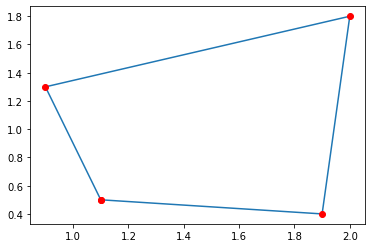

In [4]:
# symbolic math symbols
from sympy.abc import r,s
# symbolic node coordinates
x1,x2,x3,x4 = sy.symbols("x1 x2 x3 x4")
y1,y2,y3,y4 = sy.symbols("y1 y2 y3 y4")
# dictionary of numeric node coordinates for our example
Ncoo_ex = {x1:1.1, x2:1.9, x3:2.0, x4:0.9, y1:0.5, y2:0.4, y3:1.8, y4:1.3}
# use to plot the element
xcoo = list(map(Ncoo_ex.get,(x1,x2,x3,x4,x1)))
ycoo = list(map(Ncoo_ex.get,(y1,y2,y3,y4,y1)))
plt.plot(xcoo,ycoo,'-o',mec='r',mfc='r');

In [5]:
# defining bilinear shape functions
N1 = 1/4 * (1-r) * (1-s)
N2 = 1/4 * (1+r) * (1-s)
N3 = 1/4 * (1+r) * (1+s)
N4 = 1/4 * (1-r) * (1+s)
# plot the shape functions (uncomment next 3 lines if you are curious)
#from sympy.plotting import plot3d
#for Ni in (N1,N2,N3,N4):
#    plot3d(Ni,(r,-1,1),(s,-1,1))
N1

(0.25 - 0.25*r)*(1 - s)

Now to continue our example we want to integrate the function $g(x,y)=x^2+y^2$ over the element, i.e. we want solve 
\begin{align}
I &= \iint_{\Omega_{x,y}} x^2+y^2 \mathrm{d} x  \mathrm{d} y,
\end{align}
where $\Omega_{x,y}$ is the element domain.

In order to use the two-dimensional quadrature for this element as shown above, we need to compute the Jacobian.

In [6]:
from sympy.matrices import Matrix
# how global coords depend on local coords
x = N1*x1 + N2*x2 + N3*x3 + N4*x4
y = N1*y1 + N2*y2 + N3*y3 + N4*y4
# compute determinant of the Jacobian (symbolically)
X = Matrix([x,y])
R = Matrix([r,s])
J = sy.simplify(X.jacobian(R).det())
print("Jacobian determinant is:")
J

Jacobian determinant is:


-0.0625*(x1*(r - 1) - x2*(r + 1) + x3*(r + 1) - x4*(r - 1))*(y1*(s - 1) - y2*(s - 1) + y3*(s + 1) - y4*(s + 1)) + 0.0625*(x1*(s - 1) - x2*(s - 1) + x3*(s + 1) - x4*(s + 1))*(y1*(r - 1) - y2*(r + 1) + y3*(r + 1) - y4*(r - 1))

This is the Jacobian determinant in symbolical form. This means it is valid for any node coordinates of an quadrilateral element. Now lets see the result if we use our example coordinates:

In [7]:
sy.simplify(J.subs(Ncoo_ex))

0.06375*r + 0.045*s + 0.26375

Finally, we can compute the integral. We just need the Gauss support points. For second order quadrature they have coordinates $r,s = \pm \frac{1}{\sqrt{3}}$. We compute and plot the support points in global $(x,y)$ coordinates. Finally, we compute the integral.

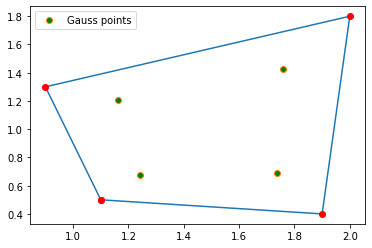

In [8]:
# this is all only for plotting
gsp = 1/np.sqrt(3) # gauss 2nd order
xgcoo = [] # list of gauss support points coordinates
ygcoo = []
for ri in (-gsp,gsp):
    for si in (-gsp,gsp):
        xgcoo.append(x.subs(Ncoo_ex).subs({r:ri, s:si}))
        ygcoo.append(y.subs(Ncoo_ex).subs({r:ri, s:si}))
# plot together with element        
plt.plot(xcoo,ycoo,'-o',mec='r',mfc='r')
plt.plot(xgcoo,ygcoo,'o',mfc='g',label="Gauss points")
plt.legend();

In [9]:
ig = (x**2+y**2)*J # the integrand symbolically
ig

(-0.0625*(x1*(r - 1) - x2*(r + 1) + x3*(r + 1) - x4*(r - 1))*(y1*(s - 1) - y2*(s - 1) + y3*(s + 1) - y4*(s + 1)) + 0.0625*(x1*(s - 1) - x2*(s - 1) + x3*(s + 1) - x4*(s + 1))*(y1*(r - 1) - y2*(r + 1) + y3*(r + 1) - y4*(r - 1)))*((x1*(0.25 - 0.25*r)*(1 - s) + x2*(1 - s)*(0.25*r + 0.25) + x3*(0.25*r + 0.25)*(s + 1) + x4*(0.25 - 0.25*r)*(s + 1))**2 + (y1*(0.25 - 0.25*r)*(1 - s) + y2*(1 - s)*(0.25*r + 0.25) + y3*(0.25*r + 0.25)*(s + 1) + y4*(0.25 - 0.25*r)*(s + 1))**2)

In [10]:
ign = sy.simplify(ig.subs(Ncoo_ex)) # integrand numerically for our example
ign

0.00179296875*r**3*s**2 + 0.00645468750000001*r**3*s + 0.01502109375*r**3 + 0.001265625*r**2*s**3 + 0.02225390625*r**2*s**2 + 0.0760359375000001*r**2*s + 0.16422578125*r**2 + 0.00725625*r*s**3 + 0.08919140625*r*s**2 + 0.2977078125*r*s + 0.62477578125*r + 0.013640625*s**3 + 0.12613046875*s**2 + 0.4135765625*s + 0.83757109375

In [11]:
I = 0 # compute the integral form four summands
for ri in (-gsp,gsp):
    for si in (-gsp,gsp):
        Is = ign.subs({r:ri, s:si})
        print(Is)
        I += Is
I

0.400585360132614
0.711302594275197
0.960836989058136
1.67459172320072


3.74731666666667

Now, how can we check that this is still an exact result?

The integrand in our example is still a polynomial ('ign', see above). So we can integrate it analytically. Because it is such a complicated expression, this looks like a lot of boring and error-prone work if we set out to do this by hand. We call Sympy to the rescue. It is able to compute the integral using symbolical mathematics. 

In [12]:
sy.integrate(ign,r,s) # indefinite integral, antiderivative

s**4*(0.00010546875*r**3 + 0.00090703125*r**2 + 0.00341015625*r) + s**3*(0.0001494140625*r**4 + 0.00247265625*r**3 + 0.014865234375*r**2 + 0.0420434895833334*r) + s**2*(0.000806835937500001*r**4 + 0.01267265625*r**3 + 0.074426953125*r**2 + 0.20678828125*r) + s*(0.0037552734375*r**4 + 0.0547419270833333*r**3 + 0.312387890625*r**2 + 0.83757109375*r)

In [13]:
sy.integrate(ign,(r,-1,1),(s,-1,1)) #  definite integral 

3.74731666666667

#### License

This notebook is an [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text and the images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), and any code under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Ennes Sarradj, Numerical Acoustics: Finite Elements: Numerical Integration (Quadrature), 2019.